<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#description" data-toc-modified-id="description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>description</a></span></li><li><span><a href="#Import" data-toc-modified-id="Import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import</a></span><ul class="toc-item"><li><span><a href="#external-library" data-toc-modified-id="external-library-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>external library</a></span></li><li><span><a href="#my-function" data-toc-modified-id="my-function-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>my function</a></span></li></ul></li><li><span><a href="#input-for-the-code" data-toc-modified-id="input-for-the-code-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>input for the code</a></span><ul class="toc-item"><li><span><a href="#load-the-microstructure" data-toc-modified-id="load-the-microstructure-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>load the microstructure</a></span></li></ul></li><li><span><a href="#run-the-code" data-toc-modified-id="run-the-code-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>run the code</a></span></li><li><span><a href="#save-results" data-toc-modified-id="save-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>save results</a></span></li><li><span><a href="#load-the-results" data-toc-modified-id="load-the-results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>load the results</a></span></li></ul></div>

# Phase-field model for growth and coarsening of Si precipitate in AlSi10Mg SLM in a super-saturated matrix
This model is based on the Kim-Kim-Suzuki model [1]
References:


[1] Kim, Kim, and Suzuki. "Phase-field model for binary alloys." Physical Review E 60:6;7186-7197 (1999).


# Import

## external library

In [1]:
import os
import numpy as np
import importlib
import collections
from os import chdir
from scipy.interpolate import UnivariateSpline #pour ma spline
import sys
import random
import importlib
from scipy.interpolate import splev, splrep
from itertools import cycle
import pyFi_adapt
importlib.reload(pyFi_adapt)
from pyFi_adapt import *
import pyvista as pv
import matplotlib.pyplot as plt


# input for the code

In [3]:
# 2 precipitates , small grid

# grid dimension
# points
Nx = 735
Ny = 735

Nz =1  # Nz=1 -> 2D 
# spacing
dx=  0.5*1e-9 # [m]

dy= 1*dx      # [m]

dz= dx # [m]


### new grid 

In [4]:
micro=np.load("micro_final.npz")

In [5]:
xyz_r=np.asarray([micro['ox_cyl'],micro['oy_cyl'],micro['oz_cyl'] ,micro['r_cyl'] ]).transpose()

In [6]:
#np.savetxt('xyz_r.txt',xyz_r)

In [7]:
import numpy as np
T_end=850
T_start=400
total_time=3* (T_end -T_start)
total_time

1350

In [8]:
Meta0 = 5.60e-8
QMeta = 1.10e+05

# time and temperature to reproduce DSC conditions

time_slm_tab1      = np.array([0,total_time])             # = time [s] 
temp_slm_tab1      = np.array([T_start,T_end])           # = temperature [K] 

X0_mat,X0_pre=0.025,0.99999       # = molar composition of the Al matrix and precipitate in SI [mol.mol-1]

tresh = 1e9

dtime_s  = 50    # = adimensional time step [-]
dtime_max=5*  dtime_s           # = maximum dimensionless time step bound [s]

nstep=5e3
print_times=20
ask_step=np.linspace(1,int(nstep),print_times,dtype=int)   # = step to save eta and Xsi 2d map 
ask_step2=np.linspace(1,int(nstep),400,dtype=int) # = step to save averag Xsi in the matrix, average eta

Lv2      = (250e-9)**2            # = vacancies mean free path [m2]


nstep   = np.max(ask_step)        # = maximum step in the simulation

alpha=2.2
Xeq  =0.025
epsX =0


lambd = 2.5*dx                    # = half of interface thickness [m] 

outfile = "precip_si"            # 


# diffusion coefficient 

D0=3.66e-6                       # = pre-exponential factor [m2.s-1]
QD=110958                        # = activation energy [J.mol-1]

c_Meta  = 1.                     # = factor for mobility []
c_D = 1.                         # = factor for diffusion [-]
c_eps0 = 0.01                        # = factor for epsilon [-]
c_gamma = 2.15                   # = factor for interface energy [-]

Meta0bis=Meta0*c_Meta            #  = interface mobility coefficient pre-exponential coefficent 


# import data

# data2 : data containing all the temperature dependant parameters
data2 = np.load("final_export.npz")
print(data2.files)

R     = 8.314472                  # = perfect gas constant[J.K-1.mol-1]

temp_tab2      = data2["T"]        # = temperature table for which the properties are given [K]
X_Si_fcc_tab2   =data2["X_Si_fcc"] # = concentration of Si in the matrix 
                                   #   at equiblrium at temperature temp_tab2 given by the phase diagram

# Free energy parabola parameter
# F=A*Xsi**2+B*XSi+C
# alpha -> matrix
# thet  -> precipitate

A_alp_tab2  = data2["A_fcc"]    # = A for alpha
B_alp_tab2  = data2["B_fcc"]    # = B for alpha
C_alp_tab2  = data2["C_fcc"]    # = C for alpha

A_thet_tab2 = data2["A_dia"]    # = A for thet
B_thet_tab2 = data2["B_dia"]    # = B for thet
C_thet_tab2 = data2["C_dia"]    # = C for thet

# stiffness coeficient for AlSi

C11_tab2         = data2["C11"]     # = [MPa]
C12_tab2         = data2["C12"]     # = [MPa]
C44_tab2         = data2["C44"]     # = [MPa]

D_inter_max_tab2 = data2["D_inter_max"]

epsX_tab2        = data2["delta"]   # = free stress strain 
L_tab2           = data2["L_max"]   # = mobility coeffient for allen-cahn

Vm_tab2          = data2["Vm"]      # = molar volume
gamma_tab2       = data2["gamma"]   # = surface enegy


D0    = data2["D0"]                 # = pre-exponential factor for diffusion [m2.s-1]
QD    =data2["QD"]                  # = activation energy for diffusion [J.mol-1]
Meta0ori =data2["Meta0"]            # = pre-exponential factor for mobility  
QMetaori =data2["QMeta"]            # = activation energy for interface velocity [J.mol-1]





['info', 'T', 'X_Si_fcc', 'Ndia', 'A_fcc', 'B_fcc', 'C_fcc', 'A_dia', 'B_dia', 'C_dia', 'Vm', 'delta', 'X_Si_D_inter', 'D_inter', 'D_inter_max', 'D_inter_min', 'gamma', 'L_eq', 'L_max', 'C11', 'C12', 'C44', 'X_Si_Gm', 'Gm_fcc', 'Gm_dia', 'D_inter_eq', 'L_DU', 'D_DU', 'D0', 'QD', 'Meta0', 'QMeta']


In [9]:
@jit(nopython=True)
def micro_numba_2(Nx,Ny,Nz,dx,dy,dz,X0_mat,X0_pre,r,ox,oy,oz):
    """
    Microstructure initialization:
    inputs: the position and radius of sphere that represents the precipitate of 
    composition X0_pre for a matrix of compositon X0_mat
    outpus: value of the variable eta and X_mat for a given grid 

    """
    eta    = np.zeros((Nx,Ny,Nz))
    X      = np.ones((Nx,Ny,Nz))*X0_mat
    X_mat  = np.ones((Nx,Ny,Nz))*X0_mat
    X_pre  = np.zeros((Nx,Ny,Nz))    
    x      = np.arange(Nx)*dx
    y      = np.arange(Ny)*dy
    z      = np.arange(Nz)*dz
    
    for i_x in range(Nx):
        for i_y in range(Ny):
            for i_z in range(Nz):
                for i_cir in range(len(r)): 
                    norm=np.sqrt((ox[i_cir]-x[i_x])**2
                    +(oy[i_cir]-y[i_y])**2
                    +(oz[i_cir]-z[i_z])**2 )
                    #+(oz[i_cir]-zcor[i_coor])**2)
                    if norm<=r[i_cir]:
                        X_pre[i_x][i_y][i_z]=X0_pre # +=
                        X_mat[i_x][i_y][i_z]=0 # +=
                        X[i_x][i_y][i_z]    =X0_pre
                        eta[i_x][i_y][i_z]  =1
                        

    return eta,X,X_mat,X_pre

## load the microstructure 

In [10]:
# cylinder
# from a file in blender 

micro_ini ="manual"

if micro_ini =="fromfile":

   # load file, format npz
    
   cyl = np.load("blender/cyl_packing.npz") # print(cyl.files)

   # assign coordinate x,y,z 

   ox_cyl=np.transpose(cyl['xyz'])[2]    # = x coordinate of the precipitate [nm]

   oy_cyl=np.transpose(cyl['xyz'])[0]    # = y coordinate of the precipitate [nm]

   oz_cyl=np.zeros(len(ox_cyl))          # = z coordinate of the precipitate [nm] -> 2D =0

   r_cyl = cyl['radius']*0.8            # = radius of the precipitate [nm]
   

   # thickness of the precipitate wall
  

   up_limit = -18.4e-9          # = before   -18.4e-9 / last -15e-9

   low_limi = -86e-9            # = before -65e-9  / last -86.5e-9


   # new coorindate of the wall

   ox_cyl_sor  =ox_cyl[(ox_cyl>low_limi)&(ox_cyl<up_limit)]

   oy_cyl_sor  =oy_cyl[(ox_cyl>low_limi)&(ox_cyl<up_limit)]

   oz_cyl_sor  =oz_cyl[(ox_cyl>low_limi)&(ox_cyl<up_limit)]

   r_cyl_sor   = r_cyl[(ox_cyl>low_limi)&(ox_cyl<up_limit)]

elif micro_ini=="manual":   
 
   [ox_cyl_sor, oy_cyl_sor, oz_cyl_sor, r_cyl_sor ]=  [xyz_r[:,0],xyz_r[:,1],xyz_r[:,2],xyz_r[:,3]] 
   #oy_cyl_sor= np.zeros(len(oy_cyl_sor))
  


eta_micro,X_micro,X_al_micro,X_th_micro=micro_numba_2(Nx,Ny,Nz,dx,dy,dz,X0_mat,

                                                    X0_pre,r_cyl_sor,ox_cyl_sor

                                                    ,oy_cyl_sor,oz_cyl_sor)


eta,X,X_al,X_th =eta_micro,X_micro,X_al_micro,X_th_micro
                                                   


### if nucleation is desired  ----------------------------------------------------------

In [11]:
eta1dred = eta.reshape(Nx*Ny*Nz)<0.05
idx = np.argwhere(eta1dred==True)

In [12]:
len(eta.reshape(Nx*Ny*Nz)), len(idx)

(540225, 497262)

In [13]:
rand = np.random.randint(0, len(idx)-1, size=25)
eta1d = eta.reshape(Nx*Ny*Nz)
eta1d[idx[rand]]=1
#eta = eta1d.reshape(Nx,Ny,Nz)



In [14]:
np.array_equal(eta,eta1d)

False

#### end nucleation insertion-------------------------------------------------------------------------------

In [15]:

"""
eta,X,X_al,X_th=put_nucle(idx,   # grid index where nucleus can be inserted 
              eta,   # order varaible  -> phase 
              X,     # conserved variable -> molar fraction of Si
              X_al,  # molar fraction of Si in al
              X_th,  # molar fraction of Si in diamond
              Nx,    # grid density in x direction 
              Ny,    # grid density in y direction 
              Nz     # # grid den
                            )
"""

'\neta,X,X_al,X_th=put_nucle(idx,   #\xa0grid index where nucleus can be inserted \n              eta,   # order varaible \xa0-> phase \n              X,     # conserved variable -> molar fraction of Si\n              X_al,  #\xa0molar fraction of Si in al\n              X_th,  # molar fraction of Si in diamond\n              Nx,    # grid density in x direction \n              Ny,    # grid density in y direction \n              Nz     # # grid den\n                            )\n'

c:\Users\seifa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\core\dataset.py:1458: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(


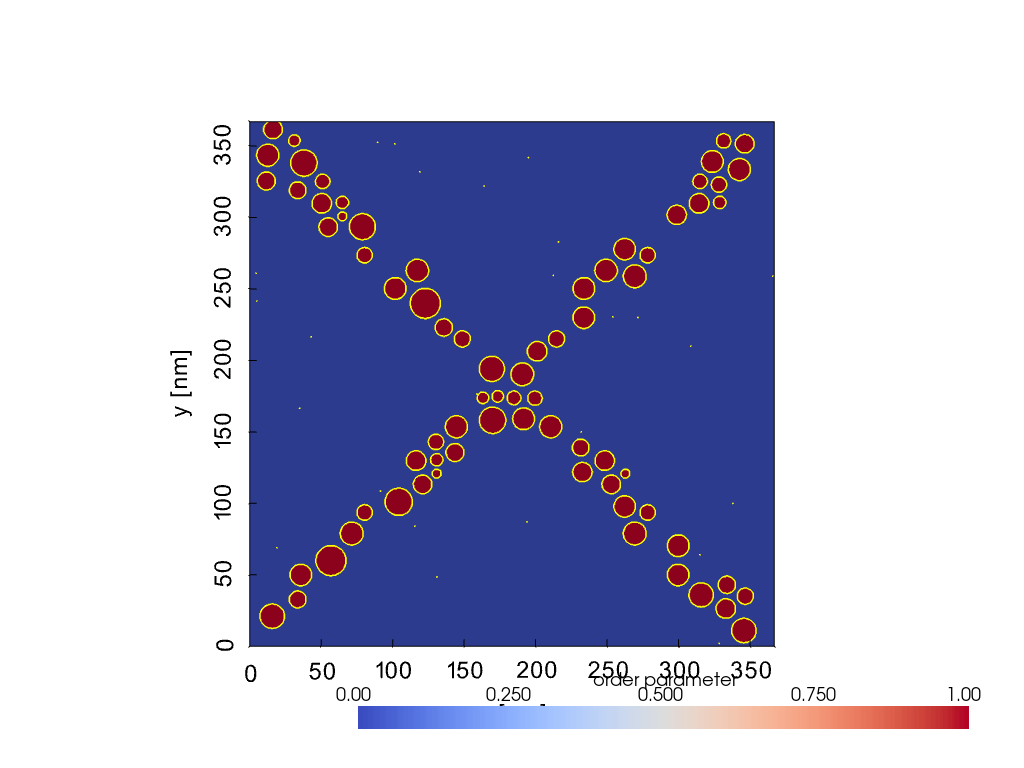

In [16]:
import sys
# grid2 : visualize eta variable
grid2 = pv.UniformGrid()
grid2.spacing=np.array([dx,dy,dz])*1E9
grid2.dimensions = np.array([Nx,Ny,Nz])#+1
grid2.point_arrays[r'order parameter'] = np.transpose(np.resize(eta,[Nx,Ny,Nz])).flatten()  # Flatten the array!

# grid : visualize X variable
grid  = pv.UniformGrid()
grid.spacing=np.array([dx,dx,dx])*1E9
grid.dimensions = np.array([Nx,Ny,Nz])#+1
grid.point_arrays[r"$X_{Si} \ [-]$"] = np.transpose(np.resize(X,[Nx,Ny,Nz])).flatten()

pv.set_plot_theme("document")           # = theme
pv.set_jupyter_backend('none')
cmap = plt.cm.get_cmap("coolwarm", 150) # = color map 
# contours for eta variable = 0.1 and 0.9
contours = grid2.contour(isosurfaces=2,rng=([0.1,0.9])) #[0.5, 1]
outline = grid.outline()
p = pv.Plotter()

p.add_mesh(outline, color="k")
p.camera_position = [0, -.75, -1]
p.add_mesh(grid2,cmap=cmap, show_scalar_bar=True,opacity=1.,clim=[0.0,1.])#)#,
p.add_mesh(contours,cmap=cmap, show_scalar_bar=True,color="y") #color="black",,clim=[1.,1.]
p.show_bounds(all_edges=True,xlabel="x [nm]",ylabel="y [nm]",zlabel="z [nm]")
sargs = dict(height=0.1, vertical=False, position_x=0.20, position_y=-0.01)
#p.show(cpos="xy")  # projection plotter.show
p.show(cpos="xy")

In [17]:
Meta0_c_Meta=Meta0*c_Meta
gamma_tab2_c_gamma=gamma_tab2*c_gamma
epsX_tab2_c_eps0=epsX_tab2*c_eps0
D0_c_D=D0*c_D
epsX_tab2_c_eps0=epsX_tab2*c_eps0
thresh_step=0

# run the code 

In [616]:
X_out,X_al_out,X_th_out,eta_out,sigel_ij_out,epsel_kl_out,eta_mean_out,deta_mean_out,X_mean_out,X_al_mean_out,dX_al_mean_out,\
          X_th_mean_out,dX_th_mean_out,dT_out,T_out,dtime_out,time_out,surf_out,dsurf_out,el_eta_s,el,G_eta_s,G_ceta_G_cc,L_out,\
           array_energy_s,array_dtime_s,good_step,ttime,array_residus_KKS,array_residus_KKS_energ_deriv,array_residus_KKS_CH,\
                array_residus_KKS_AC, array_residus_KKS_temp_term,array_time_res=\
            pyFi_adapt.main(T_start,Xeq,eta,X ,X_al,X_th,Lv2,tresh,
         Nx,Ny,Nz,dx,dy,dz,\
         temp_tab2,epsX_tab2_c_eps0,D_inter_max_tab2,\
         A_thet_tab2,B_thet_tab2,C_thet_tab2,\
         A_alp_tab2,B_alp_tab2,C_alp_tab2,\
         C11_tab2,C12_tab2,C44_tab2,\
         L_tab2,gamma_tab2_c_gamma,alpha,\
         r_cyl_sor,ox_cyl_sor,oy_cyl_sor,oz_cyl_sor,\
         time_slm_tab1,temp_slm_tab1,X0_mat,X0_pre,\
         Vm_tab2,epsX,dtime_s,nstep,ask_step,ask_step2,\
         D0_c_D,QD,Meta0_c_Meta,QMeta,X_Si_fcc_tab2,lambd,dtime_max,\
         outfile,thresh_step)   

Temperature reached : 438 K ---
simulation time : 3:58:19.321961


#### Energy evolution

In [ ]:
threshd=1
#plt.plot(time_out[good_step+threshd:1:-1], array_energy_s[good_step+threshd:1:-1])
plt.plot(time_out,array_energy_s)
plt.title('Energy evolution')

### Mean concentrations of Si in alpha and diamond phases

In [ ]:
plt.plot(time_out[good_step:-1],X_al_mean_out[good_step:-1],'r',label='X_al_alpha')
#plt.plot(time_out[good_step:-1],X_th_mean_out[good_step:-1],'c',label='X_Si_diamond')
plt.axhline(y=Xeq)
plt.xlabel('time [s]')
#plt.ylim(0.01,0.04)
plt.legend()

#### Residuals evolution

In [ ]:
# C-H
N=5 # pas
plt.plot(T_out[good_step:-1:N],array_residus_KKS[good_step:-1:N] , label=' Total', color='black')
plt.plot(T_out[good_step:-1:N],array_residus_KKS_energ_deriv[good_step:-1:N] , label=' Energy derivative', color='b')
plt.plot(T_out[good_step:-1:N],array_residus_KKS_CH[good_step:-1:N] , label=' CH', color='r')
plt.plot(T_out[good_step:-1:N],array_residus_KKS_AC[good_step:-1:N] , label=' AC', color='c')
plt.plot(T_out[good_step:-1:N],array_residus_KKS_temp_term[good_step:-1:N] , label=' Temperature term', color='m')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.8))
plt.ylabel(' Residual') 
plt.title('Evolution of the residual terms')
plt.show()


In [ ]:
plt.plot(T_out,array_dtime_s,linestyle='dashdot')
plt.ylabel(''r'$\Delta$T') 
plt.xlabel(' Temperature (K)')
plt.title('Time step evolution')

In [ ]:
import sys
# grid2 : visualize eta variable
grid2 = pv.UniformGrid()
grid2.spacing=np.array([dx,dy,dz])*1E9
grid2.dimensions = np.array([Nx,Ny,Nz])#+1
grid2.point_arrays[r'order parameter'] = np.transpose(np.resize(eta_out,[Nx,Ny,Nz])).flatten()  # Flatten the array!

# grid : visualize X variable
grid  = pv.UniformGrid()
grid.spacing=np.array([dx,dx,dx])*1E9
grid.dimensions = np.array([Nx,Ny,Nz])#+1
grid.point_arrays[r"$X_{Si} \ [-]$"] = np.transpose(np.resize(X_out,[Nx,Ny,Nz])).flatten()

pv.set_plot_theme("document")           # = theme
pv.set_jupyter_backend('none')
cmap = plt.cm.get_cmap("coolwarm", 150) # = color map 
# contours for eta variable = 0.1 and 0.9
contours = grid2.contour(isosurfaces=2,rng=([0.1,0.9])) #[0.5, 1]
outline = grid.outline()
p = pv.Plotter()

p.add_mesh(outline, color="k")
p.camera_position = [0, -.75, -1]
p.add_mesh(grid2,cmap=cmap, show_scalar_bar=True,opacity=1.,clim=[0.0,1.])#)#,
p.add_mesh(contours,cmap=cmap, show_scalar_bar=True,color="y") #color="black",,clim=[1.,1.]
p.show_bounds(all_edges=True,xlabel="x [nm]",ylabel="y [nm]",zlabel="z [nm]")
sargs = dict(height=0.1, vertical=False, position_x=0.20, position_y=-0.01)
#p.show(cpos="xy")  # projection plotter.show
p.show(cpos="xy")

## Post_process

In [2]:
def plot_micro(output,title,Nx,Ny,dx,dy,key):
    import matplotlib.pyplot as plt 
    import matplotlib.transforms as tfrms
    x_max=Nx*dx
    y_max=Ny*dy
    out=output.reshape(output.shape[0],output.shape[1]).transpose()
    if (key=='eta'):
        vmax=1
    else:
        vmax=0.025
    vmin=0
    plt.imshow(out ,extent=[0,x_max,y_max,0],vmin=vmin, vmax=vmax) #cmap='RdBu'
    plt.colorbar()
    ax = plt.gca()
    trans = tfrms.blended_transform_factory( ax.transData, ax.transAxes )
    plt.errorbar( 0, 0.0, color='k', capsize=1, transform=trans )
    ax.set_xlabel('x [nm]') 
    ax.set_ylabel('y [nm]') 
    plt.title(title)
    plt.show()

In [ ]:
"""
Save_path =os.path.join(os.getcwd(),'saved_maps') 
file_name="map650.80s_400_600.07K.npz"
dout=dict(np.load(os.path.join(Save_path, file_name)))
dout.keys()
"""

'\nSave_path =os.path.join(os.getcwd(),\'saved_maps\') \nfile_name="map650.80s_400_600.07K.npz"\ndout=dict(np.load(os.path.join(Save_path, file_name)))\ndout.keys()\n'

In [17]:
from operator import itemgetter
Save_path =os.path.join(os.getcwd(),'saved_maps') # _Big_grid
array_filenames=[]
array_Temp=[]
for filename in os.listdir(Save_path):
    array_filenames.append(filename)
    array_Temp.append(filename[-11:-8])
array_index=sorted(range(len(array_Temp)), key=lambda k: array_Temp[k])
array_Temp.sort(key = int)
array_filenames.sort(key = len)
print(array_Temp)

array_index=sorted(range(len(array_filenames)), key=lambda k: array_Temp[k])

array_filenames_sorted=[]
for i in range(len(array_filenames)):
    array_filenames_sorted.append(array_filenames[array_index[i]])
array_filenames=array_filenames_sorted    
print(array_filenames)


['400', '739']
['map0.02s_400_400.00K.npz', 'map1727.75s_400_739.09K.npz']


In [18]:
# array of dictionaries 
array_dict=[]


for i in range(len(array_filenames)):
    file_name=array_filenames[i]
    temp=array_Temp
    str='dout_'+array_Temp[i]
    globals()[str]=dict(np.load(os.path.join(Save_path, file_name)))
    array_dict.append(globals()[str])
    

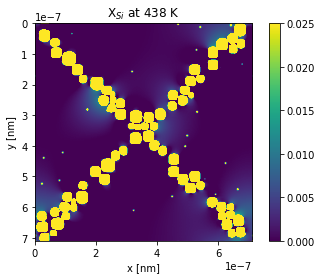

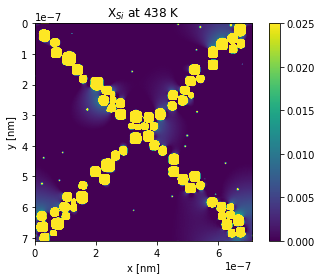

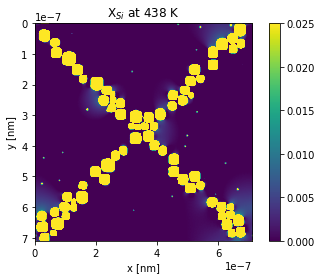

In [28]:
key='X'
for i in range(len(array_filenames)):
    Var=array_dict[i][key]
    title=key+'$_{Si}$ at '+array_Temp[i]+' K'
    plot_micro(Var,title,Nx,Ny,dx,dy,key)

c:\Users\seifa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\core\dataset.py:1458: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(


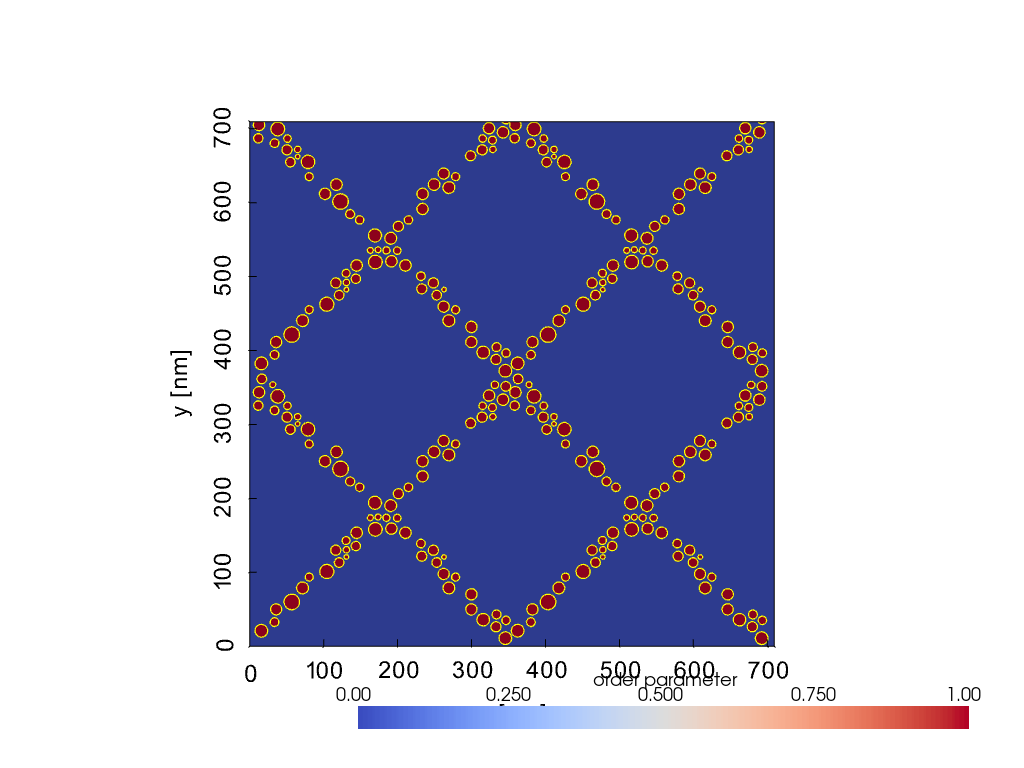

In [8]:
eta_out=array_dict[0]['eta']
X_out=array_dict[0]['X']
Nx = eta_out.shape[0]
Ny = eta_out.shape[1]
import sys
# grid2 : visualize eta variable
grid2 = pv.UniformGrid()
grid2.spacing=np.array([dx,dy,dz])*1E9
grid2.dimensions = np.array([Nx,Ny,Nz])#+1
grid2.point_arrays[r'order parameter'] = np.transpose(np.resize(eta_out,[Nx,Ny,Nz])).flatten()  # Flatten the array!

# grid : visualize X variable
grid  = pv.UniformGrid()
grid.spacing=np.array([dx,dx,dx])*1E9
grid.dimensions = np.array([Nx,Ny,Nz])#+1
grid.point_arrays[r"$X_{Si} \ [-]$"] = np.transpose(np.resize(X_out,[Nx,Ny,Nz])).flatten()

pv.set_plot_theme("document")           # = theme
pv.set_jupyter_backend('none')
cmap = plt.cm.get_cmap("coolwarm", 150) # = color map 
# contours for eta variable = 0.1 and 0.9
contours = grid2.contour(isosurfaces=2,rng=([0.1,0.9])) #[0.5, 1]
outline = grid.outline()
p = pv.Plotter()

p.add_mesh(outline, color="k")
p.camera_position = [0, -.75, -1]
p.add_mesh(grid2,cmap=cmap, show_scalar_bar=True,opacity=1.,clim=[0.0,1.])#)#,
p.add_mesh(contours,cmap=cmap, show_scalar_bar=True,color="y") #color="black",,clim=[1.,1.]
p.show_bounds(all_edges=True,xlabel="x [nm]",ylabel="y [nm]",zlabel="z [nm]")
sargs = dict(height=0.1, vertical=False, position_x=0.20, position_y=-0.01)
#p.show(cpos="xy")  # projection plotter.show
p.show(cpos="xy")

# ------------------------------------------------------------------------------

# plot and save  all maps images  (Matplotlib library)

In [ ]:
#check step
array_dict[0]['T_out'].max(),array_dict[-1]['T_out'].max()

(460.2149599025649, 693.0195628759648)

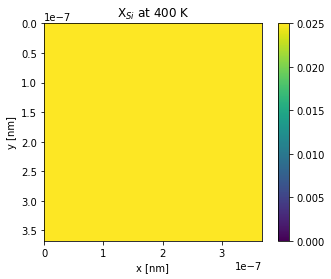

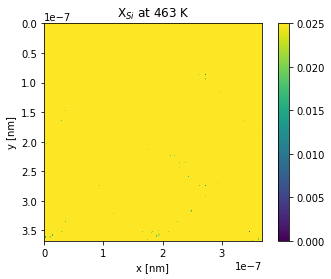

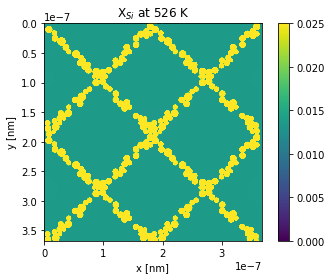

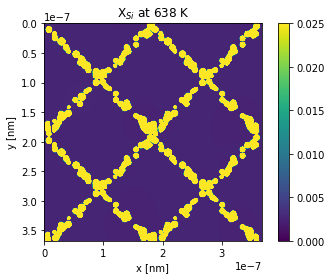

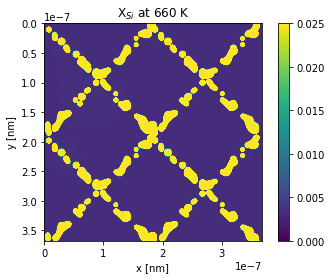

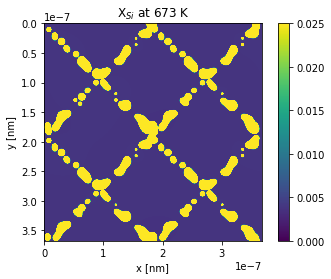

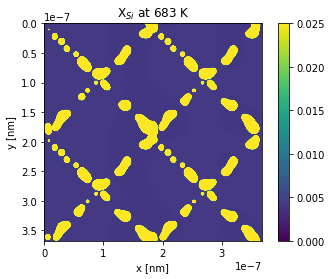

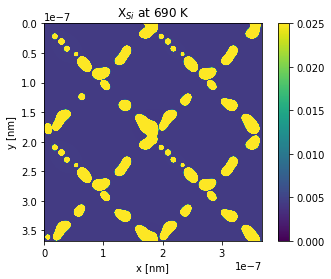

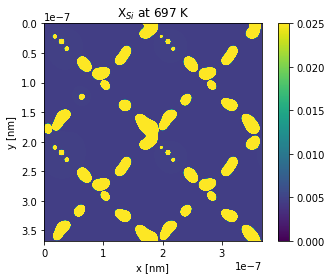

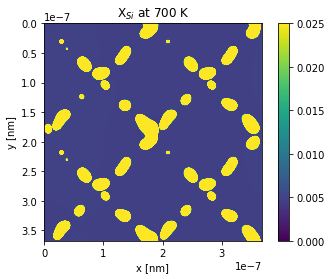

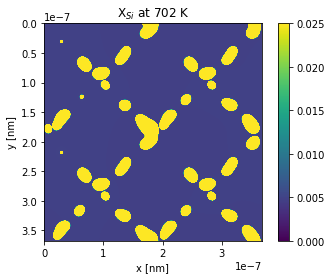

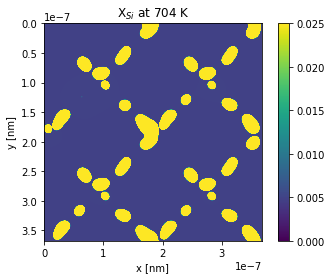

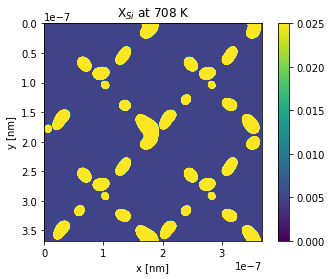

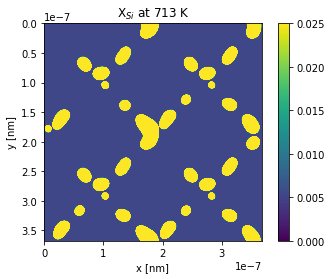

In [82]:
key='X'
for i in range(len(array_Temp)):
    Var=array_dict[i][key]
    title=key+'$_{Si}$ at '+array_Temp[i]+' K'
    plot_micro(Var,title,Nx,Ny,dx,dy,key)

    

### Cell for maximum temperature

In [4]:
eta_out=array_dict[-1]['eta']
X_out=array_dict[-1]['X']
Nx = eta_out.shape[0]
Ny = eta_out.shape[1]
Nz =1  
dx=  0.5*1e-9 # [m]
dy= 1*dx      # [m]
dz= dx # [m]

# X_Si : Pyvista library 

In [9]:
eta_out=array_dict[-1]['eta']
X_out=array_dict[-1]['X']
Nx = eta_out.shape[0]
Ny = eta_out.shape[1]
Nz =1  
dx=  0.5*1e-9 # [m]
dy= 1*dx      # [m]
dz= dx # [m]

In [10]:
key='X'
for i in range(len(array_dict)): #len(array_dict)):
    eta_out=array_dict[i]['eta']
    X_out=array_dict[i]['X']
    # plot microstructure

    # grid2 : visualize eta variable
    grid2 = pv.UniformGrid()
    grid2.spacing=np.array([dx,dx,dx])*1E9
    grid2.dimensions = np.array([Nx,Ny,Nz])#+1
    grid2.point_data['X$_{Si}$'] = np.transpose(np.resize(eta_out,[Nx,Ny,Nz])).flatten()  # Flatten the array!

    # grid : visualize X variable
    grid  = pv.UniformGrid()
    grid.spacing=np.array([dx,dx,dx])*1E9
    grid.dimensions = np.array([Nx,Ny,Nz])#+1
    grid.point_data["Si [mol. %]"] = np.transpose(np.resize(X_out*100,[Nx,Ny,Nz])).flatten()


    pv.set_plot_theme("document")           # = theme
    cmap = plt.cm.get_cmap("coolwarm", 350) # = color map 

    # contours for eta variable = 0.1 and 0.9
    contours = grid2.contour(isosurfaces=2,rng=([0.1,0.9])) #[0.5, 1]

    outline = grid.outline()

    sargs = dict(height=0.7, vertical=True, position_x=0.8, position_y=0.15,label_font_size=20,font_family="arial")  #title='X_Si [mol. %]'
    #sargs = dict(interactive=True)

    p = pv.Plotter(off_screen=True) #notebook=False


    p.add_mesh(outline, color="k")

    p.camera_position =  'xy'
    p.update_scalar_bar_range([0,2.5], name=None)
    p.add_mesh(contours,cmap=cmap,  color="yellow") #color="black",,clim=[1.,1.]
    p.add_mesh(grid,cmap='rainbow' ,show_scalar_bar=True,scalar_bar_args=sargs, opacity=0.9,clim=[0,2.5])#)#,
    

    p.show_bounds(all_edges=True,xlabel="x [nm]",ylabel="y [nm]",zlabel="z [nm]")

    title=key+'r"_{Si}$" at '+array_Temp[i]+' K'

    p.add_text(array_Temp[i]+' K',  position=(0.45,0.65), color='y', shadow=True, font_size=16, viewport='True')
    #p.add_title(title)
    p.screenshot("X_Si"+array_Temp[i]+'_K'+".png")  #jupyter_backend='None'



# eta

In [20]:
key='eta'
for i in range(len(array_dict)):    
    eta_out=array_dict[i]['eta']
    X_out=array_dict[i]['X']
    Nx = eta_out.shape[0]
    Ny = eta_out.shape[1]
    import sys
    # grid2 : visualize eta variable
    grid2 = pv.UniformGrid()
    grid2.spacing=np.array([dx,dy,dz])*1E9
    grid2.dimensions = np.array([Nx,Ny,Nz])#+1
    grid2.point_data[r'$X_{Si} \ [-]$'] = np.transpose(np.resize(eta_out,[Nx,Ny,Nz])).flatten()  # Flatten the array!
    
    # grid : visualize X variable
    grid  = pv.UniformGrid()
    grid.spacing=np.array([dx,dx,dx])*1E9
    grid.dimensions = np.array([Nx,Ny,Nz])#+1
    grid.point_data[r"eta"] = np.transpose(np.resize(X_out,[Nx,Ny,Nz])).flatten()
    sargs = dict(height=0.7, vertical=True, position_x=0.8, position_y=0.15,label_font_size=20,font_family="arial")  #title='X_Si [mol. %]'
    pv.set_plot_theme("document")           # = theme
    pv.set_jupyter_backend('none')
    cmap = plt.cm.get_cmap("coolwarm", 150) # = color map 
    # contours for eta variable = 0.1 and 0.9
    contours = grid2.contour(isosurfaces=2,rng=([0.1,0.9])) #[0.5, 1]
    outline = grid.outline()

    p = pv.Plotter()
    
    p.add_mesh(outline, color="k")
    p.camera_position = [0, -.75, -1]
    p.add_mesh(grid2,cmap=cmap, show_scalar_bar=True,scalar_bar_args=sargs,opacity=1.,clim=[0.0,1.])#)#,
    p.add_mesh(contours,cmap=cmap, show_scalar_bar=True,color="y") #color="black",,clim=[1.,1.]
    p.show_bounds(all_edges=True,xlabel="x [nm]",ylabel="y [nm]",zlabel="z [nm]")
    sargs = dict(height=0.1, vertical=False, position_x=0.20, position_y=-0.01)
    #p.show(cpos="xy")  # projection plotter.show
    
    p.camera_position =  'xy'

    title=key+'r"_{Si}$" at '+array_Temp[i]+' K'

    p.add_text(array_Temp[i]+' K',  position=(0.45,0.65), color='y', shadow=True, font_size=16, viewport='True')
    #p.add_title(title)
    p.screenshot("eta"+array_Temp[i]+'_K'+".png")  #jupyter_backend='None'

In [16]:
simulation_time=4754
print(datetime.timedelta(seconds=simulation_time))

1:19:14
